# Connect to Google Drive

In [ ]:
# you will be prompted with a window asking to grant permissions
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# fill in the path in your Google Drive in the string below. Note: do not escape slashes or spaces
import os
import shutil
basedir = "/content/drive/My Drive/cs444/course_project" # basedir for Nic
#basedir = "/content/drive/My Drive/course_project" # basedir for Suri
if not os.path.exists(basedir):
  !ln -s "/content/drive/My Drive/cs444/course_project"
os.chdir(basedir)
#import person_segmentation.person_sgg
!pwd

/content/drive/.shortcut-targets-by-id/1nsXbKssFpk42EbRJhkAp5KzJayoKaaGU/course_project


In [ ]:
# Initialize additional paths
python_scripts_dir = basedir + "/Python Scripts"
cycle_gan_dir = basedir + "/pytorch-CycleGAN-and-pix2pix"
cycle_gan_model_dir = cycle_gan_dir + "/models"

# Install Dependencies

In [ ]:
!pip install people_segmentation  > /dev/null
!pip install iglovikov_helper_functions

!pip install iglovikov_helper_functions

In [ ]:
# Imports
%matplotlib inline
from pylab import imshow
import numpy as np
import cv2
import torch
import albumentations as albu
from scipy.linalg import sqrtm
from contextlib import contextmanager
from os import listdir
from tqdm import tqdm
import matplotlib.pyplot as plt

import torchvision
from google.colab.patches import cv2_imshow
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

from iglovikov_helper_functions.utils.image_utils import load_rgb, pad, unpad
from iglovikov_helper_functions.dl.pytorch.utils import tensor_from_rgb_image

# Load utilities from python_scripts_dir
os.chdir(python_scripts_dir)
from get_frames import *
from visualize import *
from utils_deepfashion import *
os.chdir(basedir)

# Load iterative texture transfer
os.chdir(basedir + "/texture_transfer")
from imagequiltingtexturetransfer import iterative_texture_transfer
os.chdir(basedir)

# Load MaskCNN

In [ ]:
!wget https://habrastorage.org/webt/em/l7/cr/eml7crxnxftrimsmolwjegqcrp4.jpeg > /dev/null
!pip install people_segmentation  > /dev/null

--2023-05-12 05:43:50--  https://habrastorage.org/webt/em/l7/cr/eml7crxnxftrimsmolwjegqcrp4.jpeg
Resolving habrastorage.org (habrastorage.org)... 51.89.30.72
Connecting to habrastorage.org (habrastorage.org)|51.89.30.72|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://hsto.org/webt/em/l7/cr/eml7crxnxftrimsmolwjegqcrp4.jpeg [following]
--2023-05-12 05:43:50--  https://hsto.org/webt/em/l7/cr/eml7crxnxftrimsmolwjegqcrp4.jpeg
Resolving hsto.org (hsto.org)... 104.26.12.161, 172.67.71.175, 104.26.13.161, ...
Connecting to hsto.org (hsto.org)|104.26.12.161|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 55211 (54K) [image/jpeg]
Saving to: ‘eml7crxnxftrimsmolwjegqcrp4.jpeg.4’

eml7crxnxftrimsmolw 100%[===================>]  53.92K  --.-KB/s    in 0.004s  

2023-05-12 05:43:51 (14.1 MB/s) - ‘eml7crxnxftrimsmolwjegqcrp4.jpeg.4’ saved [55211/55211]



In [ ]:
# Old MaskCNN
"""
# Load model
from people_segmentation.pre_trained_models import create_model
model = create_model("Unet_2020-07-20")
model.eval()

# Load example image
image = cv2.imread(basedir + "/Data/Video_Frames/15/15_1.jpg")
image = image[:, :, [2, 1, 0]]
plt.imshow(image)

# Make prediction and store mask
transform = albu.Compose([albu.Normalize(p=1)], p=1)
padded_image, pads = pad(image, factor=32, border=cv2.BORDER_CONSTANT)

x = transform(image=padded_image)["image"]
x = torch.unsqueeze(tensor_from_rgb_image(x), 0)

with torch.no_grad():
  prediction = model(x)[0][0]

mask = (prediction > 0).cpu().numpy().astype(np.uint8)

# Apply mask to blacken masked pixels
mask = unpad(mask, pads)

style_transfered_img = padded_image.copy()
style_transfered_img[np.where(mask==1)] = 0
plt.imshow(style_transfered_img), plt.show()
imshow(mask)

dst = cv2.addWeighted(image, 1, (cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB) * (0, 255, 0)).astype(np.uint8), 0.5, 0)
imshow(dst)
"""

'\n# Load model\nfrom people_segmentation.pre_trained_models import create_model\nmodel = create_model("Unet_2020-07-20")\nmodel.eval()\n\n# Load example image\nimage = cv2.imread(basedir + "/Data/Video_Frames/15/15_1.jpg")\nimage = image[:, :, [2, 1, 0]]\nplt.imshow(image)\n\n# Make prediction and store mask\ntransform = albu.Compose([albu.Normalize(p=1)], p=1)\npadded_image, pads = pad(image, factor=32, border=cv2.BORDER_CONSTANT)\n\nx = transform(image=padded_image)["image"]\nx = torch.unsqueeze(tensor_from_rgb_image(x), 0)\n\nwith torch.no_grad():\n  prediction = model(x)[0][0]\n\nmask = (prediction > 0).cpu().numpy().astype(np.uint8)\n\n# Apply mask to blacken masked pixels\nmask = unpad(mask, pads)\n\nstyle_transfered_img = padded_image.copy()\nstyle_transfered_img[np.where(mask==1)] = 0\nplt.imshow(style_transfered_img), plt.show()\nimshow(mask)\n\ndst = cv2.addWeighted(image, 1, (cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB) * (0, 255, 0)).astype(np.uint8), 0.5, 0)\nimshow(dst)\n'

# Utils for New Mask CNN

In [ ]:
def get_instance_segmentation_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model


def draw_bounding_box(img, box):

    x_min, y_min = int(box[0]),int(box[1])
    x_max, y_max = int(box[2]),int(box[3])

    img= cv2.rectangle(img, (x_min,y_min), (x_max,y_max), color=(0,255,0), thickness=2)
    cv2_imshow(img)
    return (img)

def overlay(image, mask, color, alpha, resize=None):
    """Combines image and its segmentation mask into a single image.
    https://www.kaggle.com/code/purplejester/showing-samples-with-segmentation-mask-overlay

    Params:
        image: Training image. np.ndarray,
        mask: Segmentation mask. np.ndarray,
        color: Color for segmentation mask rendering.  tuple[int, int, int] = (255, 0, 0)
        alpha: Segmentation mask's transparency. float = 0.5,
        resize: If provided, both image and its mask are resized before blending them together.
        tuple[int, int] = (1024, 1024))

    Returns:
        image_combined: The combined image. np.ndarray

    """
    color = color[::-1]
    colored_mask = np.expand_dims(mask, 0).repeat(3, axis=0)
    colored_mask = np.moveaxis(colored_mask, 0, -1)
    masked = np.ma.MaskedArray(image, mask=colored_mask, fill_value=color)
    image_overlay = masked.filled()

    if resize is not None:
        image = cv2.resize(image.transpose(1, 2, 0), resize)
        image_overlay = cv2.resize(image_overlay.transpose(1, 2, 0), resize)

    image_combined = cv2.addWeighted(image, 1 - alpha, image_overlay, alpha, 0)

    return image_combined


# Load New Mask CNN

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model  = get_instance_segmentation_model(2)
model.to(device)

path = basedir + '/Models/person_model.torch'
model.load_state_dict(torch.load(path, map_location=device)) # change accordingly

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<All keys matched successfully>

# Example use of New Mask CNN with test iamge

In [ ]:
model.eval()
# read image for prediction
test_im_path = basedir + "/Data/Style_Transfer_Frames/15/stylemonet_pretrained/test_latest/images/real/15_1_real.png"

im = cv2.imread(test_im_path)
im= torch.as_tensor(im,dtype= torch.float32)
im= im.swapaxes(0, 2).swapaxes(1, 2)/255
# predict bounding box and mask
pred = model([im.to(device)])

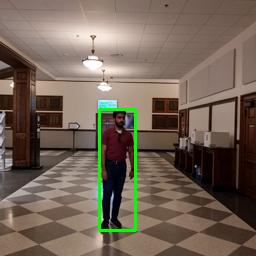

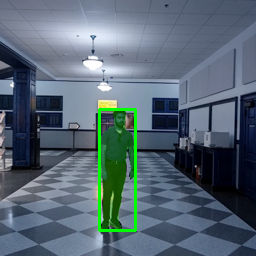

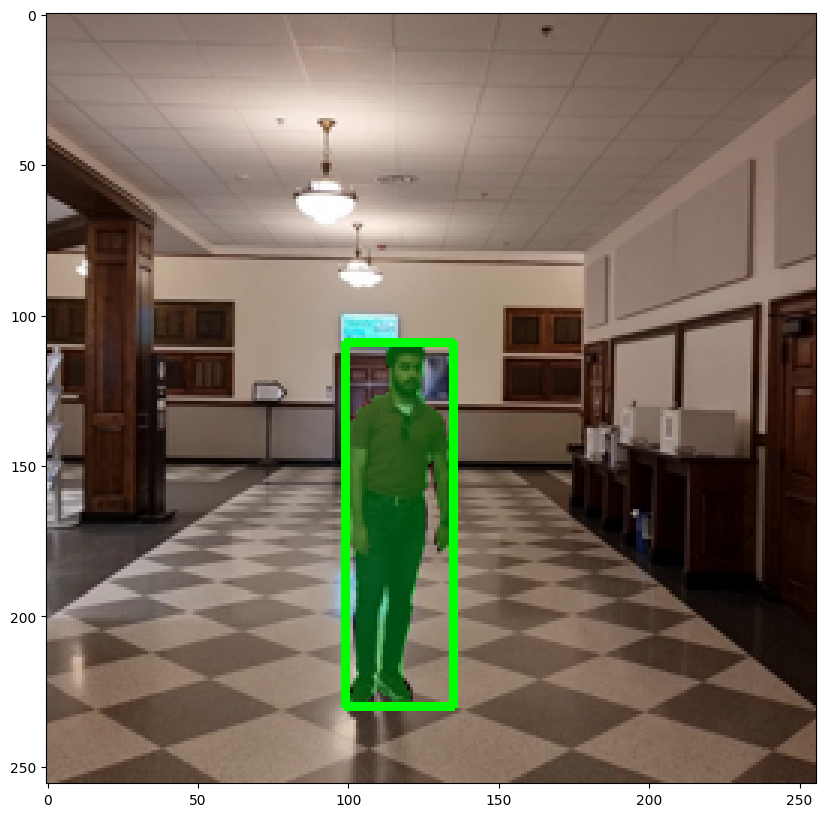

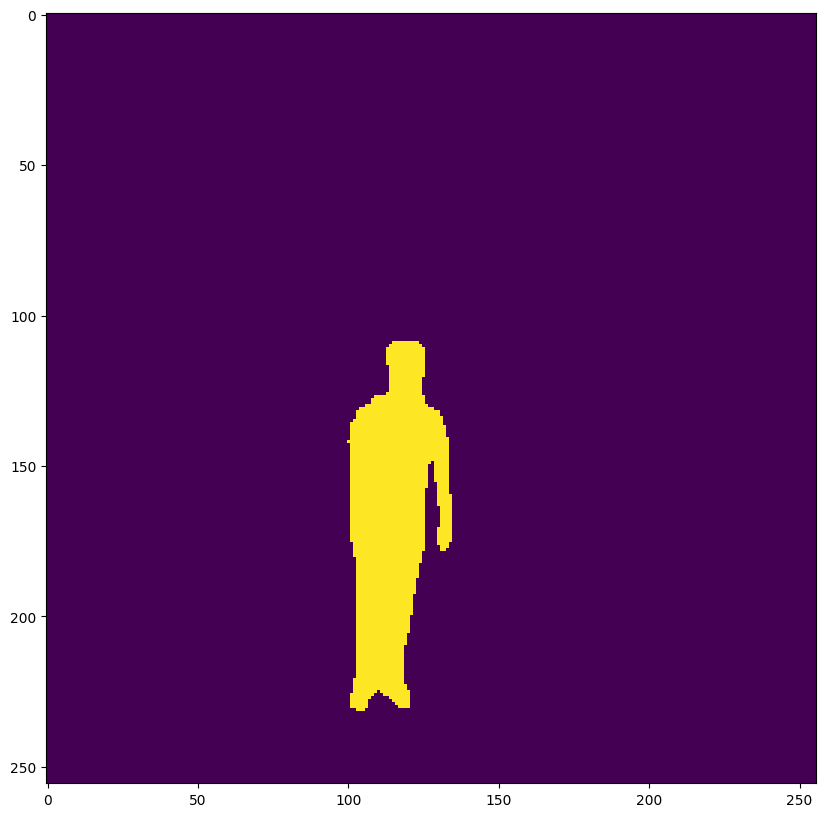

In [ ]:
# view image with bounding box and mask ################################
im = cv2.imread(test_im_path)
for idx in range(2):
  im = draw_bounding_box(im, pred[0]['boxes'].cpu().detach()[0])
  mask= pred[0]['masks']
  mask[mask<0.5]=0

  mask= mask[0,0].cpu().detach().numpy()
  im = overlay(im, mask, color=(0,255,800), alpha=0.3)
  im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

  plt.figure(figsize=(10,10))
  plt.imshow(im)

########################################################################

# view mask ############################################################
mask = torch.as_tensor(mask,dtype= torch.bool)
plt.imshow(mask)
########################################################################

#(Pseudo) Code
1. Convert video to directory of frame images
2. Execute GAN and or CUT on directory of frame images
    - Creates new directory of outputs
3. Call get_combined_frames() to obtain a list of combined frames and generate directory containing all combined frames
    - Load all filenames from GAN or CUT output directories and original video frame directory
    - Sort filenames to ensure both loads are in the same sequential order
    - For each pair of corresponding filenames in the two lists:
      - Load original and generated frames
      - Apply MaskCNN on original frame
      - Copy pixels from original frame to generated frame where mask==1 (person was detected)
      - Save combined frame to output directory, and append to list containing all combined frames (to be returned)
4. Leverage compile_frames_to_video() to convert and save list of combined frames into a video



In [ ]:
def get_combined_frames(orig_frame_dir, gan_frame_dir, out_frame_dir, MaskCNN):
  combined_frames = []

  # Loop through all frames in orig_frame_dir
  orig_listdir = os.listdir(orig_frame_dir)
  gan_listdir = os.listdir(gan_frame_dir)

  orig_listdir.sort(key=lambda x: int(x.split('_')[-2]))
  gan_listdir.sort(key=lambda x: int(x.split('_')[-2]))

  for orig_im_name, gan_im_name in zip(orig_listdir, gan_listdir):
    # Load original frame
    path = orig_frame_dir + '/' + orig_im_name
    orig_frame = cv2.imread(path)
    #orig_frame = orig_frame[:, :, [2, 1, 0]]
    #plt.imshow(orig_frame), plt.show()

    # Load GAN output frame
    path = gan_frame_dir + '/' + gan_im_name
    gan_frame = cv2.imread(path)
    #gan_frame = gan_frame[:, :, [2, 1, 0]]
    #plt.imshow(gan_frame), plt.show()


    """# Extract person map with old MaskCNN
    transform = albu.Compose([albu.Normalize(p=1)], p=1)
    padded_image, pads = pad(orig_frame, factor=32, border=cv2.BORDER_CONSTANT)

    x = transform(image=padded_image)["image"]
    x = torch.unsqueeze(tensor_from_rgb_image(x), 0)

    with torch.no_grad():
      prediction = MaskCNN(x)[0][0]

    mask = (prediction > 0).cpu().numpy().astype(np.uint8)
    mask = unpad(mask, pads)"""

    # Extract person map with new MaskCNN
    im= torch.as_tensor(orig_frame,dtype= torch.float32)
    im= im.swapaxes(0, 2).swapaxes(1, 2)/255

    pred = model([im.to(device)])
    mask= pred[0]['masks']
    mask[mask<0.5]=0
    mask[mask>=0.5] = 1

    combined_frame = gan_frame
    if mask.shape[0] != 0:
      # Paste original pixel values where mask==1 into transformed image (transfer people pixels from original to gan output frame)
      mask= mask[0,0].cpu().detach().numpy()
      combined_frame[np.where(mask==1)] = orig_frame[np.where(mask==1)]


    #combined_frame[np.where(mask==1)] = 0 # Blacks out the people
    #plt.imshow(original_img), plt.show()

    # Save combined frame to output dir
    path = out_frame_dir + '/' + orig_im_name
    cv2.imwrite(path, combined_frame)

    # Store combined frame
    combined_frames.append(combined_frame)

  return combined_frames

In [ ]:
# Executes the GAN on a directory of video frames
# dataroot should be consistent with output_path above
"""
# Code to decompose video into directory of frames
#extract_frames(video_path, output_path, n=2, downsample_factor=5) # Only need to uncomment and run this when first operating on a new video (that hasn't had frames extracted yet)

# Code to run GAN on directory created above
with cwd(cycle_gan_dir):
  # !pip install -r requirements.txt
  !python test.py --dataroot /content/drive/MyDrive/course_project/Data/Video_Frames/15 --name stylemonet_pretrained --model test --no_dropout --results_dir /content/drive/MyDrive/course_project/Data/Style_Transfer_Frames/15
"""

"\n# Code to decompose video into directory of frames\n#extract_frames(video_path, output_path, n=2, downsample_factor=5) # Only need to uncomment and run this when first operating on a new video (that hasn't had frames extracted yet)\n\n# Code to run GAN on directory created above\nwith cwd(cycle_gan_dir):\n  # !pip install -r requirements.txt\n  !python test.py --dataroot /content/drive/MyDrive/course_project/Data/Video_Frames/15 --name stylemonet_pretrained --model test --no_dropout --results_dir /content/drive/MyDrive/course_project/Data/Style_Transfer_Frames/15\n"

In [ ]:
all_dirs = ['1'] # For when you want to specify specific videos by name
#all_dirs = os.listdir(basedir + '/Data/Style_Transfer_Frames/') # For when you want to run every video in the directory

# Instantiate MaskCNN model
MaskCNN = model#create_model("Unet_2020-07-20")

for base_frames_dir in all_dirs:
  # Params for combining frames
  orig_frame_dir = basedir + "/Data/Style_Transfer_Frames/" + base_frames_dir + "/stylemonet_pretrained/test_latest/images/real"
  gan_frame_dir = basedir + "/Data/Style_Transfer_Frames/" + base_frames_dir + "/stylemonet_pretrained/test_latest/images/fake"
  out_frame_dir = basedir + "/Data/Style_Transfer_Frames/" + base_frames_dir + "/stylemonet_pretrained/test_latest/images/combined"
  #orig_frame_dir = basedir + "/frames_for_report/original"
  #gan_frame_dir = basedir + "/frames_for_report/CUT"
  #out_frame_dir = basedir + "/frames_for_report/CUT_with_people"

  # This is the path for the CUT output for one image. Comment the following code if you want to run it only for the CycleGAN
  #gan_frame_dir = '/content/drive/MyDrive/course_project/CUT/checkpoints/vid2monet/test_latest/images/fake_B'

  # Ensure out_frame_dir exists
  if not os.path.exists(out_frame_dir):
    os.makedirs(out_frame_dir)

  # Transform all frames of video, leaving people unchanged
  #combined_frames = get_combined_frames(frames, CycleGAN, MaskCNN)
  combined_frames = get_combined_frames(orig_frame_dir, gan_frame_dir, out_frame_dir, MaskCNN)

  # Recompile combined_frames into a new video
  outdir = basedir + '/GAN_video_outputs/' + base_frames_dir + ".avi"
  compile_frames_to_video(combined_frames, outdir)

# Texture Transfer Driver Code

In [ ]:
def get_combined_frames_texture_transfer(orig_frame_dir, out_frame_dir, MaskCNN, monet_guide_dir):
  texture_img = cv2.cvtColor(cv2.imread(monet_guide_dir), cv2.COLOR_BGR2RGB)

  out_size = 256
  num_passes = 5
  patch_size = 71
  overlap = 13
  tol = 2

  combined_frames = []

  # Loop through all frames in orig_frame_dir
  orig_listdir = os.listdir(orig_frame_dir)
  orig_listdir.sort(key=lambda x: int(x.split('_')[-2]))

  for i in tqdm(range(len(orig_listdir))):#orig_im_name in orig_listdir:
    orig_im_name = orig_listdir[i]

    # Load original frame
    path = orig_frame_dir + '/' + orig_im_name
    orig_frame = cv2.imread(path)
    #print(orig_frame.shape)

    """# Extract person map with MaskCNN
    transform = albu.Compose([albu.Normalize(p=1)], p=1)
    padded_image, pads = pad(orig_frame, factor=32, border=cv2.BORDER_CONSTANT)

    x = transform(image=padded_image)["image"]
    x = torch.unsqueeze(tensor_from_rgb_image(x), 0)

    with torch.no_grad():
      prediction = MaskCNN(x)[0][0]

    mask = (prediction > 0).cpu().numpy().astype(np.uint8)
    mask = unpad(mask, pads)"""

    # Extract person map with new MaskCNN
    im= torch.as_tensor(orig_frame,dtype= torch.float32)
    im= im.swapaxes(0, 2).swapaxes(1, 2)/255

    pred = model([im.to(device)])
    mask= pred[0]['masks']
    mask[mask<0.5]=0
    mask[mask>=0.5] = 1

    mask= mask[0,0].cpu().detach().numpy()

    # Perform iterative texture transfer on the frame
    texture_transfer_frame = iterative_texture_transfer(texture_img, orig_frame, out_size, num_passes, patch_size, overlap, tol)

    # Paste original pixel values where mask==1 into transformed image (transfer people pixels from original to gan output frame)
    combined_frame = texture_transfer_frame[:,:,[2,1,0]]
    combined_frame[np.where(mask==1)] = orig_frame[np.where(mask==1)]
    #combined_frame[np.where(mask==1)] = 0 # Blacks out the people

    # Save combined frame to output dir
    path = out_frame_dir + '/' + orig_im_name
    cv2.imwrite(path, combined_frame)

    # Store combined frame
    combined_frames.append(combined_frame)

  return combined_frames

  0%|          | 0/8 [00:00<?, ?it/s]

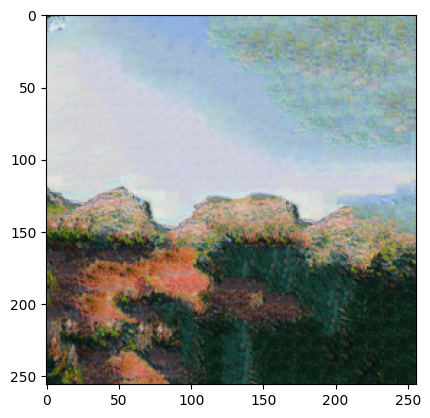

 12%|█▎        | 1/8 [03:20<23:23, 200.47s/it]

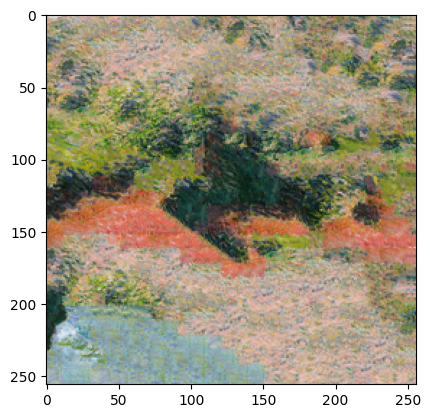

 25%|██▌       | 2/8 [06:24<19:03, 190.62s/it]

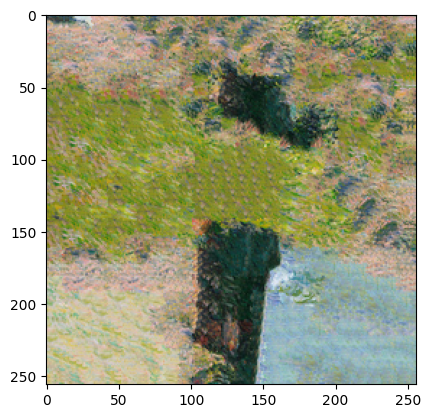

 38%|███▊      | 3/8 [09:26<15:34, 186.86s/it]

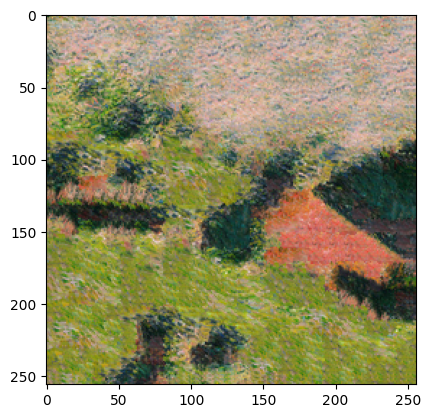

 50%|█████     | 4/8 [12:29<12:20, 185.24s/it]

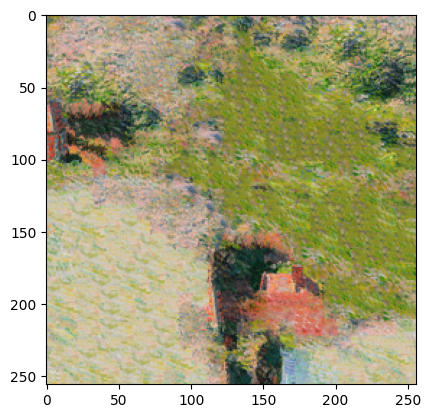

 62%|██████▎   | 5/8 [15:32<09:13, 184.37s/it]

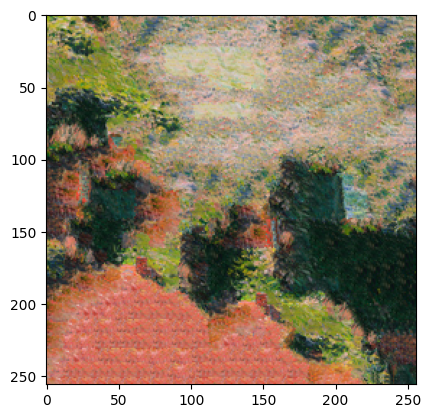

 75%|███████▌  | 6/8 [18:36<06:08, 184.47s/it]

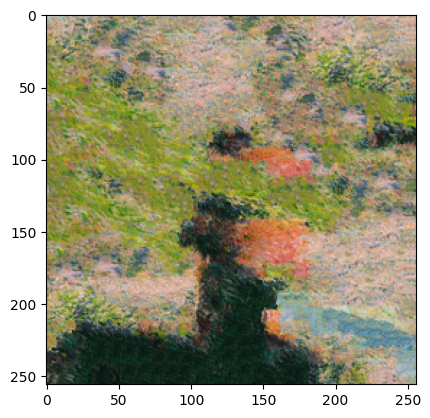

 88%|████████▊ | 7/8 [21:38<03:03, 183.63s/it]

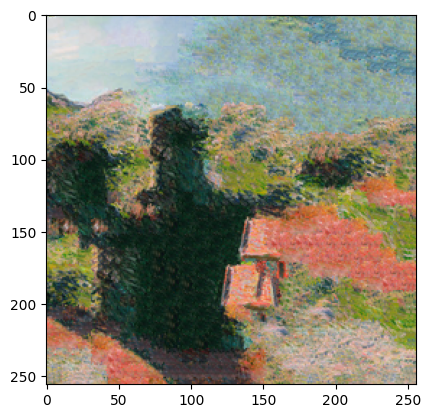

100%|██████████| 8/8 [24:41<00:00, 185.21s/it]


In [ ]:
all_dirs = ['original'] # For when you want to specify specific videos by name
#all_dirs = os.listdir(basedir + '/Data/Style_Transfer_Frames/') # For when you want to run every video in the directory

monet_guide_dir = 'texture_transfer/samples/monet_6.jpg'

# Instantiate MaskCNN model
MaskCNN = model

for base_frames_dir in all_dirs:
  # Params for combining frames
  #orig_frame_dir = basedir + "/Data/Style_Transfer_Frames/" + base_frames_dir + "/stylemonet_pretrained/test_latest/images/real"
  #out_frame_dir = basedir + "/Data/Style_Transfer_Frames/" + base_frames_dir + "/stylemonet_pretrained/test_latest/images/combined_texture_transfer"
  orig_frame_dir = basedir + "/frames_for_report/" + base_frames_dir
  out_frame_dir = basedir + "/frames_for_report/iterative_texture_transfer_monet_6"

  # Ensure out_frame_dir exists
  if not os.path.exists(out_frame_dir):
    os.makedirs(out_frame_dir)

  # Transform all frames of video, leaving people unchanged
  #combined_frames = get_combined_frames(frames, CycleGAN, MaskCNN)
  combined_frames = get_combined_frames_texture_transfer(orig_frame_dir, out_frame_dir, MaskCNN, monet_guide_dir)

  # Recompile combined_frames into a new video
  #outdir = basedir + '/Texture_Transfer_video_outputs/' + base_frames_dir + ".avi"
  #compile_frames_to_video(combined_frames, outdir)

In [ ]:
all_dirs = ['original'] # For when you want to specify specific videos by name
#all_dirs = os.listdir(basedir + '/Data/Style_Transfer_Frames/') # For when you want to run every video in the directory

monet_guide_dir = 'texture_transfer/samples/monet_5.jpg'

# Instantiate MaskCNN model
MaskCNN = model

for base_frames_dir in all_dirs:
  # Params for combining frames
  #orig_frame_dir = basedir + "/Data/Style_Transfer_Frames/" + base_frames_dir + "/stylemonet_pretrained/test_latest/images/real"
  #out_frame_dir = basedir + "/Data/Style_Transfer_Frames/" + base_frames_dir + "/stylemonet_pretrained/test_latest/images/combined_texture_transfer"
  orig_frame_dir = basedir + "/frames_for_report/" + base_frames_dir
  out_frame_dir = basedir + "/frames_for_report/iterative_texture_transfer_monet_5"

  # Ensure out_frame_dir exists
  if not os.path.exists(out_frame_dir):
    os.makedirs(out_frame_dir)

  # Transform all frames of video, leaving people unchanged
  #combined_frames = get_combined_frames(frames, CycleGAN, MaskCNN)
  combined_frames = get_combined_frames_texture_transfer(orig_frame_dir, out_frame_dir, MaskCNN, monet_guide_dir)

  # Recompile combined_frames into a new video
  #outdir = basedir + '/Texture_Transfer_video_outputs/' + base_frames_dir + ".avi"
  #compile_frames_to_video(combined_frames, outdir)

In [ ]:
all_dirs = ['original'] # For when you want to specify specific videos by name
#all_dirs = os.listdir(basedir + '/Data/Style_Transfer_Frames/') # For when you want to run every video in the directory

monet_guide_dir = 'texture_transfer/samples/monet_1.jpg'

# Instantiate MaskCNN model
MaskCNN = model

for base_frames_dir in all_dirs:
  # Params for combining frames
  #orig_frame_dir = basedir + "/Data/Style_Transfer_Frames/" + base_frames_dir + "/stylemonet_pretrained/test_latest/images/real"
  #out_frame_dir = basedir + "/Data/Style_Transfer_Frames/" + base_frames_dir + "/stylemonet_pretrained/test_latest/images/combined_texture_transfer"
  orig_frame_dir = basedir + "/frames_for_report/" + base_frames_dir
  out_frame_dir = basedir + "/frames_for_report/iterative_texture_transfer_monet_1"

  # Ensure out_frame_dir exists
  if not os.path.exists(out_frame_dir):
    os.makedirs(out_frame_dir)

  # Transform all frames of video, leaving people unchanged
  #combined_frames = get_combined_frames(frames, CycleGAN, MaskCNN)
  combined_frames = get_combined_frames_texture_transfer(orig_frame_dir, out_frame_dir, MaskCNN, monet_guide_dir)

  # Recompile combined_frames into a new video
  #outdir = basedir + '/Texture_Transfer_video_outputs/' + base_frames_dir + ".avi"
  #compile_frames_to_video(combined_frames, outdir)

In [ ]:
all_dirs = ['original'] # For when you want to specify specific videos by name
#all_dirs = os.listdir(basedir + '/Data/Style_Transfer_Frames/') # For when you want to run every video in the directory

monet_guide_dir = 'texture_transfer/samples/monet_2.jpg'

# Instantiate MaskCNN model
MaskCNN = model

for base_frames_dir in all_dirs:
  # Params for combining frames
  #orig_frame_dir = basedir + "/Data/Style_Transfer_Frames/" + base_frames_dir + "/stylemonet_pretrained/test_latest/images/real"
  #out_frame_dir = basedir + "/Data/Style_Transfer_Frames/" + base_frames_dir + "/stylemonet_pretrained/test_latest/images/combined_texture_transfer"
  orig_frame_dir = basedir + "/frames_for_report/" + base_frames_dir
  out_frame_dir = basedir + "/frames_for_report/iterative_texture_transfer_monet_2"

  # Ensure out_frame_dir exists
  if not os.path.exists(out_frame_dir):
    os.makedirs(out_frame_dir)

  # Transform all frames of video, leaving people unchanged
  #combined_frames = get_combined_frames(frames, CycleGAN, MaskCNN)
  combined_frames = get_combined_frames_texture_transfer(orig_frame_dir, out_frame_dir, MaskCNN, monet_guide_dir)

  # Recompile combined_frames into a new video
  #outdir = basedir + '/Texture_Transfer_video_outputs/' + base_frames_dir + ".avi"
  #compile_frames_to_video(combined_frames, outdir)

In [ ]:
for i in range(len(combined_frames)):
  combined_frames[i] = combined_frames[i][:,:,[2,1,0]]

compile_frames_to_video(combined_frames, outdir)

Success! Video saved to:  /content/drive/My Drive/cs444/course_project/Texture_Transfer_video_outputs/1.avi


In [ ]:
all_dirs = ['4'] # For when you want to specify specific videos by name
#all_dirs = os.listdir(basedir + '/Data/Style_Transfer_Frames/') # For when you want to run every video in the directory

for base_frames_dir in all_dirs:
  # Params for combining frames
  orig_frame_dir = basedir + "/Data/Style_Transfer_Frames/" + base_frames_dir + "/stylemonet_pretrained/test_latest/images/real"
  out_frame_dir = basedir + "/Data/Style_Transfer_Frames/" + base_frames_dir + "/stylemonet_pretrained/test_latest/images/combined_texture_transfer"

  # Ensure out_frame_dir exists
  if not os.path.exists(out_frame_dir):
    os.makedirs(out_frame_dir)

  # Instantiate MaskCNN model
  MaskCNN = model

  # Transform all frames of video, leaving people unchanged
  #combined_frames = get_combined_frames(frames, CycleGAN, MaskCNN)
  combined_frames = get_combined_frames_texture_transfer(orig_frame_dir, out_frame_dir, MaskCNN)

  # Recompile combined_frames into a new video
  outdir = basedir + '/Texture_Transfer_video_outputs/' + base_frames_dir + ".avi"
  compile_frames_to_video(combined_frames, outdir)

In [ ]:
side_by_side_frames = []
new_frame_shape = (frames[0].shape[0], frames[0].shape[1] * 2, 3)
for i in tqdm(range(len(frames))):
  new_frame = np.zeros(new_frame_shape, dtype=int)

  new_frame[:, 0:frames[0].shape[1]] = frames[i]
  new_frame[:, frames[0].shape[1]:] = transformed_frames[i]
  side_by_side_frames.append(new_frame.astype('uint8'))

  #plt.imshow(side_by_side_frames[i]), plt.show()

# Recompile side_by_side_frames into a new video
outdir = basedir + "/video_out_comparisson.avi"
compile_frames_to_video(side_by_side_frames, outdir)

100%|██████████| 153/153 [00:00<00:00, 929.53it/s]


Success! Video saved to:  /content/drive/My Drive/cs444/course_project/video_out_comparisson.avi


# Mask R-CNN attempt 2

In [ ]:
os.chdir(python_scripts_dir)
import utils_deepfashion
import visualize
os.chdir(basedir)

ModuleNotFoundError: ignored

In [ ]:
def person_detection(path_image):
  device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
  person_info = person_segmentation.person_sgg.persons_sgg_im(path_image, device)
  return person_info

# CycleGAN

Function to change path when calling CycleGAN

In [ ]:
@contextmanager
def cwd(path):
    oldpwd = os.getcwd()
    os.chdir(path)
    try:
        yield
    finally:
        os.chdir(oldpwd)

In [ ]:
os.listdir(out_path)

['13',
 '14',
 '12',
 'test_video',
 '9',
 '8',
 '7',
 '6',
 '5',
 '4',
 '1',
 '11',
 '10',
 '3',
 '2',
 '15']

Run CycleGAN on frames and store images in /content/drive/MyDrive/course_project/Data/Style_Transfer_Frames

In [ ]:
with cwd(cycle_gan_dir):
  # !pip install -r requirements.txt
  !python test.py --dataroot /content/drive/MyDrive/course_project/Data/Video_Frames/15 --name stylemonet_pretrained --model test --no_dropout --results_dir /content/drive/MyDrive/course_project/Data/Style_Transfer_Frames/15

----------------- Options ---------------
             aspect_ratio: 1.0                           
               batch_size: 1                             
          checkpoints_dir: /content/drive/MyDrive/course_project/pytorch-CycleGAN-and-pix2pix/checkpoints/
                crop_size: 256                           
                 dataroot: /content/drive/MyDrive/course_project/Data/Video_Frames/15	[default: None]
             dataset_mode: single                        
                direction: AtoB                          
          display_winsize: 256                           
                    epoch: latest                        
                     eval: False                         
                  gpu_ids: 0                             
                init_gain: 0.02                          
                init_type: normal                        
                 input_nc: 3                             
                  isTrain: False                     

Separate real and fake frames into two separate folders

In [ ]:
out_names = os.listdir(os.path.join(basedir,'Data/Video_Frames'))
out_names

['13',
 '14',
 '12',
 'test_video',
 '9',
 '8',
 '7',
 '6',
 '5',
 '4',
 '1',
 '11',
 '10',
 '3',
 '2',
 '15']

In [ ]:
for out in out_names:
  # Path to the directory containing the images
  directory_path = os.path.join('/content/drive/MyDrive/course_project/Data/Style_Transfer_Frames',out,'stylemonet_pretrained/test_latest/images')
  # Create 'real' and 'fake' directories
  real_dir = os.path.join(directory_path, 'real')
  fake_dir = os.path.join(directory_path, 'fake')
  os.makedirs(real_dir, exist_ok=True)
  os.makedirs(fake_dir, exist_ok=True)

  # Loop through the files in the directory
  for filename in os.listdir(directory_path):
      # Check if the file ends with '_real.png'
      if filename.endswith('_real.png'):
          source_path = os.path.join(directory_path, filename)
          destination_path = os.path.join(real_dir, filename)
          shutil.move(source_path, destination_path)
      # Check if the file ends with '_fake.png'
      elif filename.endswith('_fake.png'):
          source_path = os.path.join(directory_path, filename)
          destination_path = os.path.join(fake_dir, filename)
          shutil.move(source_path, destination_path)

# Evaluate GANs

In [ ]:
MAX_TRAIN_SAMPLES = 200
TARGET_PATH = '/content/drive/MyDrive/course_project/pytorch-CycleGAN-and-pix2pix/datasets/monet2photo/testA'
FAKE_IMAGE_PATH = '/content/drive/MyDrive/course_project/Data/Style_Transfer_Frames/stylemonet_pretrained/test_latest/images/fake'

Code from https://www.kaggle.com/code/nicholaslincoln/comparing-pix2pix-cyclegan-with-inception-score. Since we do not have paired images, we are using the Monet images provided in the CycleGAN repo as target domain images, and the CycleGAN output on our input images as the generated images.

In [ ]:
class DataLoader():
    def __init__(self, dataset_folder_path, img_size=(256, 256)):
        """
        Constructs a DataLoader object

        :params:
            dataset_folder_path (str): The path to the folder of
                images to be loaded.  This is the name of the Pix2Pix dataset,
                like edges2shoes.
            image_shape (tuple): Tuple of the image dimensions like (x, y).
        """
        self.dataset_folder_path = dataset_folder_path
        self.img_size = img_size
        self.nbr_batches = None

    def load_data(self, batch_size=1, use_for_training=True):
        """
        Loads data
        """
        image_files = os.listdir(self.dataset_folder_path)
        image_files = [self.dataset_folder_path + "/" + i for i in image_files]
        if MAX_TRAIN_SAMPLES is not None:
            image_files = image_files[:MAX_TRAIN_SAMPLES]

        # randomly sample batch_size number of images from the given path
        batch_images = np.random.choice(image_files, size=batch_size)

        # source_images = []
        target_images = []

        for img_path in batch_images:
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            target_images.append(img)

        # stack the batch images into a numpy array and scale pixels
        #   to range from -1 to 1
        target_images = np.array(target_images)/127.5 - 1.

        return target_images

In [ ]:
def load_real_samples(batch_size, nbr_patches):
    """
    Uses a DataLoader object to load a batch of real image
    samples.  Returns the source and target images, along with the
    label (label = all ones because they are all real images).
    """
    loader = DataLoader(
        dataset_folder_path=TARGET_PATH,
    )
    real_target_images = loader.load_data(
        batch_size=batch_size,
        use_for_training=True
    )
    y = np.ones((len(real_target_images), nbr_patches, nbr_patches, 1))
    return real_target_images, y

def load_fake_samples(batch_size, nbr_patches):
    """
    Uses a DataLoader object to load a batch of fake image
    samples.  Returns the source and fake images, along with the
    label (label = all zeros because they are all fake images).
    """
    loader = DataLoader(
        dataset_folder_path=FAKE_IMAGE_PATH,
    )
    real_target_images = loader.load_data(
        batch_size=batch_size,
        use_for_training=True
    )
    y = np.zeros((len(real_target_images), nbr_patches, nbr_patches, 1))
    return real_target_images, y

In [ ]:
from keras.applications.inception_v3 import InceptionV3

class EvalGAN:
    def __init__(self, real_images, fake_images):
        self.real_images = real_images
        self.fake_images = fake_images
        self.model = InceptionV3(
            include_top=False,
            pooling='avg',
            input_shape=(256, 256, 3)
        )

    def calculate_fid(self):
        """
        Calculates the Frechet Inception Distance (FID) score.
        """
        # calculate activations
        act1 = self.model.predict(self.real_images)
        act2 = self.model.predict(self.fake_images)
        # calculate mean and covariance statistics
        mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
        mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)
        # calculate sum squared difference between means
        ssdiff = np.sum((mu1 - mu2)**2.0)
        # calculate sqrt of product between cov
        covmean = sqrtm(sigma1.dot(sigma2))
        # check and correct imaginary numbers from sqrt
        if np.iscomplexobj(covmean):
            covmean = covmean.real
        # calculate score
        fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
        return fid

In [ ]:
real_target_images,_ = load_real_samples(batch_size=5, nbr_patches=1)
fake_target_images,_ = load_fake_samples(batch_size=5, nbr_patches=1)

geval = EvalGAN(real_target_images, fake_target_images)
fid = geval.calculate_fid()
print("CycleGAN FID:", fid)

1/1 [==============================] - 0s 33ms/step
CycleGAN FID: 659.7579015890202


In [ ]:
!pwd

/content/drive/.shortcut-targets-by-id/1nsXbKssFpk42EbRJhkAp5KzJayoKaaGU/course_project


In [ ]:
python_scripts_dir = '/content/drive/MyDrive/course_project/Python Scripts'

os.chdir(python_scripts_dir)

import get_frames as gf
# from get_frames import extract_frames, extract_and_return_frames, compile_frames_to_video
from visualize import *
from utils_deepfashion import *

In [ ]:
vids = os.listdir(os.path.join(basedir,'Data/Videos'))
vids = [os.path.join(basedir,'Data/Videos',x) for x in vids]
print('Number of videos: ',len(vids))
out_path = os.path.join(basedir,'Data/Video_Frames')
for vid in vids:
    gf.extract_frames(vid,out_path)
print('Done!')

Number of videos:  16
13
Frames extracted: 44
14
Frames extracted: 54
12
Frames extracted: 45
test_video
Frames extracted: 16
9
Frames extracted: 64
8
Frames extracted: 37
7
Frames extracted: 45
6
Frames extracted: 46
5
Frames extracted: 61
4
Frames extracted: 42
1
Frames extracted: 78
11
Frames extracted: 67
10
Frames extracted: 38
3
Frames extracted: 45
2
Frames extracted: 49
15
Frames extracted: 32
Done!


In [ ]:
os.chdir(basedir)